In [1]:
import json
from pathlib import Path
import pandas as pd
import numpy as np
from tqdm import tqdm

from mplsoccer import Pitch, VerticalPitch





def load_competitions(sb_data_root: Path) -> pd.DataFrame:
    comp_path = sb_data_root / "competitions.json"
    comps = json.loads(comp_path.read_text(encoding="utf-8"))
    return pd.DataFrame(comps)

TARGET = [
    ("England", "Premier League"),
 #   ("Spain", "La Liga"),
  #  ("Italy", "Serie A"),
   # ("Germany", "1. Bundesliga"),
]

def pick_competitions_1516(comps):
    selected = []

    for country, comp in TARGET:
        sel = comps[
            (comps["country_name"] == country) &
            (comps["competition_name"] == comp) &
            (comps["season_name"] == "2015/2016")
        ]

        if sel.empty:
            raise ValueError(f"Missing: {country} {comp} 2015/2016")

        selected.append(sel.iloc[0])

    return pd.DataFrame(selected)


def load_matches(sb_data_root: Path, competition_id: int, season_id: int) -> pd.DataFrame:
    p = sb_data_root / "matches" / str(competition_id) / f"{season_id}.json"
    matches = json.loads(p.read_text(encoding="utf-8"))
    return pd.DataFrame(matches)

def _safe_id(x):
    if isinstance(x, dict) and "id" in x: return x["id"]
    return np.nan

def _safe_name(x):
    if isinstance(x, dict) and "name" in x: return x["name"]
    return None

def flatten_events_for_match(sb_data_root: Path, match_row: dict) -> pd.DataFrame:
    match_id = match_row["match_id"]
    p = sb_data_root / "events" / f"{match_id}.json"
    ev = json.loads(p.read_text(encoding="utf-8"))

    rows = []
    for e in ev:
        loc = e.get("location", None)
        x = loc[0] if isinstance(loc, list) and len(loc) >= 2 else np.nan
        y = loc[1] if isinstance(loc, list) and len(loc) >= 2 else np.nan

        # end locations (pass/carry)
        endx = endy = np.nan
        pass_length = np.nan
        pass_subtype = None

        if "pass" in e and e["pass"] is not None:
            end = e["pass"].get("end_location", None)
            if isinstance(end, list) and len(end) >= 2:
                endx, endy = end[0], end[1]
            pass_length = e["pass"].get("length", np.nan)
            pass_subtype = _safe_name(e["pass"].get("type"))
        elif "carry" in e and e["carry"] is not None:
            end = e["carry"].get("end_location", None)
            if isinstance(end, list) and len(end) >= 2:
                endx, endy = end[0], end[1]

        rows.append({
            "match_id": match_id,
            "competition_id": match_row["competition"]["competition_id"] if isinstance(match_row.get("competition"), dict) else match_row.get("competition_id"),
            "season_id": match_row["season"]["season_id"] if isinstance(match_row.get("season"), dict) else match_row.get("season_id"),
            "competition_name": match_row.get("competition", {}).get("competition_name", None) if isinstance(match_row.get("competition"), dict) else None,
            "season_name": match_row.get("season", {}).get("season_name", None) if isinstance(match_row.get("season"), dict) else None,

            "type": _safe_name(e.get("type")),
            "play_pattern": _safe_name(e.get("play_pattern")),
            "team_id": _safe_id(e.get("team")),
            "team_name": _safe_name(e.get("team")),
            "possession": e.get("possession", np.nan),
            "possession_team_id": _safe_id(e.get("possession_team")),
            "possession_team_name": _safe_name(e.get("possession_team")),

            "minute": e.get("minute", np.nan),
            "second": e.get("second", np.nan),
            "timestamp": e.get("timestamp", None),  
            "duration": e.get("duration", np.nan),  
            "period" : e.get("period", np.nan),

            "x": x, "y": y,
            "endx": endx, "endy": endy,

            "pass_length": pass_length,
            "pass_subtype": pass_subtype,
        })

    return pd.DataFrame(rows)

def load_all_events_1516(sb_data_root: Path) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    comps = load_competitions(sb_data_root)
    picked = pick_competitions_1516(comps)

    all_matches = []
    for _, r in picked.iterrows():
        m = load_matches(sb_data_root, int(r["competition_id"]), int(r["season_id"]))
        # enrich for convenience
        m["competition_name"] = r["competition_name"]
        m["season_name"] = r["season_name"]
        all_matches.append(m)

    matches_df = pd.concat(all_matches, ignore_index=True)

    # Load events
    event_dfs = []
    for _, mr in matches_df.iterrows():
        event_dfs.append(flatten_events_for_match(sb_data_root, mr.to_dict()))

    events_df = pd.concat(event_dfs, ignore_index=True)

    # create a "league" label that matches your normalization bucket
    events_df["league_season"] = events_df["competition_name"].fillna("") + " | " + events_df["season_name"].fillna("")
    matches_df["league_season"] = matches_df["competition_name"].fillna("") + " | " + matches_df["season_name"].fillna("")

    return comps, matches_df, events_df


In [2]:
from functions import (
    calc_width, calc_directness, calc_tempo,
    calc_pressing_height, calc_pressing_intensity,
    calc_pass_length, get_progressive_actions, calc_possession_time
)
from tqdm import tqdm

def build_team_match_features_1516(sb_data_root: Path) -> pd.DataFrame:
    comps = load_competitions(sb_data_root)
    picked = pick_competitions_1516(comps)

    all_feature_rows = []

    for _, r in picked.iterrows():

        matches = load_matches(
            sb_data_root,
            int(r["competition_id"]),
            int(r["season_id"])
        )

        league_label = r["competition_name"] + " | " + r["season_name"]

        for _, match in tqdm(
            matches.iterrows(),
            total=len(matches),
            desc=f"{league_label}",
            leave=False
        ):
            events = flatten_events_for_match(sb_data_root, match.to_dict())

            actions = get_progressive_actions(events)

            f_width = calc_width(actions, match=True)
            f_dir   = calc_directness(actions, match=True)
            f_tempo = calc_tempo(events, match=True)
            f_ph    = calc_pressing_height(events)
            f_pi    = calc_pressing_intensity(events)
            f_pl    = calc_pass_length(events, match=True)

            merged = (
                f_width
                .merge(f_dir, on=["match_id","team_id"], how="outer")
                .merge(f_tempo, on=["match_id","team_id"], how="outer")
                .merge(f_ph, on=["match_id","team_id"], how="outer")
                .merge(f_pi, on=["match_id","team_id"], how="outer")
                .merge(f_pl, on=["match_id","team_id"], how="outer")
            )
            team_map = events[["team_id", "team_name"]].drop_duplicates()
            merged = merged.merge(team_map, on="team_id", how="left")

            merged["league_season"] = league_label
            all_feature_rows.append(merged)

            # free memory
            del events, actions, f_width, f_dir, f_tempo, f_ph, f_pi, f_pl, merged

    return pd.concat(all_feature_rows, ignore_index=True)



In [3]:
def team_season_agg(team_match_df: pd.DataFrame, events_df: pd.DataFrame) -> pd.DataFrame:
    # attach league_season + team_name
    meta = events_df[["match_id","team_id","team_name","league_season"]].drop_duplicates()
    tm = team_match_df.merge(meta, on=["match_id","team_id"], how="left")

    # aggregate over matches → team-season profile
    # (mean is fine for intent; you can also add std later)
    group_cols = ["league_season", "team_id", "team_name"]
    feature_cols = [c for c in tm.columns if c not in set(group_cols + ["match_id"])]

    team_season = tm.groupby(group_cols)[feature_cols].mean(numeric_only=True).reset_index()
    return team_season
def attach_league_meta(team_match_df, events_df):
    meta = (
        events_df[["match_id","team_id","team_name","league_season"]]
        .drop_duplicates()
    )
    return team_match_df.merge(meta, on=["match_id","team_id"], how="left")

def zscore_within_league_season(team_season_df: pd.DataFrame) -> pd.DataFrame: #For full season
    df = team_season_df.copy()
    id_cols = ["league_season", "team_id", "team_name"]
    feat_cols = [c for c in df.columns if c not in id_cols]

    def zgrp(g):
        mu = g[feat_cols].mean()
        sd = g[feat_cols].std(ddof=0).replace(0, np.nan)
        gz = (g[feat_cols] - mu) / sd
        g_out = g[id_cols].copy()
        for c in feat_cols:
            g_out[c] = gz[c]
        return g_out

    return df.groupby("league_season", group_keys=False).apply(zgrp).reset_index(drop=True)

def zscore_match_within_league(team_match_df: pd.DataFrame) -> pd.DataFrame: #Per mathc level
    df = team_match_df.copy()

    id_cols = ["league_season","match_id","team_id","team_name"]
    feat_cols = [c for c in df.columns if c not in id_cols]

    def zgrp(g):
        mu = g[feat_cols].mean()
        sd = g[feat_cols].std(ddof=0).replace(0, np.nan)

        gz = (g[feat_cols] - mu) / sd

        g_out = g[id_cols].copy()
        for c in feat_cols:
            g_out[c] = gz[c]

        return g_out

    return (
        df.groupby("league_season", group_keys=False)
          .apply(zgrp)
          .reset_index(drop=True)
    )



In [4]:
from pathlib import Path
import os
DATA_ROOT = Path(os.environ["EXJOBB_DATA"])
sb_root = DATA_ROOT / "open-data-master" / "data"
matches_dir = sb_root / "matches"
events_dir  = sb_root / "events"
three_dir   = sb_root / "three-sixty"
comps = pd.read_json(sb_root / "competitions.json")
team_match = build_team_match_features_1516(sb_root)   # NEW memory-safe builder

# team-season aggregation (no events_df needed)
feature_cols = [c for c in team_match.columns if c not in ["league_season","team_id","team_name","match_id"]]

team_season = (
    team_match
    .groupby(["league_season","team_id","team_name"], as_index=False)[feature_cols]
    .mean(numeric_only=True)
)




#team_season_z = zscore_within_league_season(team_season)

#team_season_z.to_csv("team_season_intent_1516_z.csv", index=False)
#print("Saved: team_season_intent_1516_z.csv")


Premier League | 2015/2016:   0%|          | 0/380 [00:00<?, ?it/s]/Users/stefanivchenko/code/exjobb/functions.py:342: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c] = df[c].astype("Int64")
/Users/stefanivchenko/code/exjobb/functions.py:343: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["pass_width"] = abs(df["endy"] - 40)
Premier League | 2015/2016:   0%|          | 1/380 [00:00<00:40,  9.41it/s]/Users/stefanivchenko/code/exjobb/functions.py:342: SettingWithCopyWarning: 
A value is trying to be set

In [5]:
TACTICAL_COLS = [
    "mean_width",
    "directness",
    "tempo",
    "press_height_mean_x",
    "press_intensity",
    "mean_pass_length"
]


team_match_clean = team_match[
    ["match_id", "team_id", "team_name", "league_season"] + TACTICAL_COLS
].copy()


In [6]:
poss = functions.calc_possession_time(events, match=True)
tot = poss.groupby("match_id")["possession_seconds"].sum() / 60
print(tot.describe())
print(tot.sort_values(ascending=False).head(10))


NameError: name 'functions' is not defined

In [9]:
team_match.groupby("match_id")[["possession_minutes","opp_possession_minutes"]].sum()


,possession_minutes,opp_possession_minutes
match_id,,
3753972,110.566294,77.986868
3753973,107.499197,76.123838
3753974,103.771361,25.421324
3753975,110.282042,23.778556
3753976,110.296363,35.794729
...,...,...
3754347,104.347059,26.877910
3754348,104.152757,66.547999
3754349,100.924411,20.071787


In [ ]:
mid = 3753972
events = pd.read_json(events_dir / f"{mid}.json")
events["match_id"] = mid
if "team_id" not in events.columns and "team" in events.columns:
    events["team_id"] = events["team"].apply(lambda x: x.get("id") if isinstance(x, dict) else np.nan)

poss = calc_possession_time(events, match=True)
print(poss)
print("total minutes:", poss["possession_seconds"].sum()/60)


   match_id  team_id  possession_seconds
0   3753972       26         1643.832528
1   3753972       28         4989.967106
total minutes: 110.56332723333331


In [ ]:
# after you have df with t_abs_sec and t_end_abs_sec
df = df.sort_values(["match_id", "t_abs_sec"]).copy()

# pick one match
mid = 3753972
d = df[df["match_id"] == mid].copy()

# build segments the way your current code does
seg_old = (
    d.groupby(["period","possession","possession_team_id"], as_index=False)
     .agg(start=("t_abs_sec","min"), end=("t_end_abs_sec","max"))
)
seg_old["dur"] = (seg_old["end"] - seg_old["start"]).clip(lower=0)

print(seg_old["dur"].describe())
print(seg_old.sort_values("dur", ascending=False).head(10)[["period","possession","possession_team_id","dur"]])


NameError: name 'df' is not defined

In [ ]:
cluster_cols = [
    "mean_width",
    "directness",
    "tempo",
    "mean_pass_length",
    "std_pass_length",
    "press_height_mean_x",
    "press_height_std_x",
    "press_intensity",
]

cluster_summary = team_season_z.groupby("cluster")[cluster_cols].mean()
cluster_summary


,mean_width,directness,tempo,mean_pass_length,std_pass_length,press_height_mean_x,press_height_std_x,press_intensity
cluster,,,,,,,,
0,1.377434,-0.601316,-0.179380,-0.170709,-0.494605,1.202141,-0.213114,1.289553
1,0.087021,-0.959972,0.774240,-1.089370,-1.079181,0.442388,-0.615340,0.398698
2,-0.259325,0.450793,-0.738829,0.366867,0.559672,-0.509393,0.289703,-0.403342
3,-1.160252,1.753320,1.271080,1.873270,1.460928,-0.838107,0.862029,-1.315386


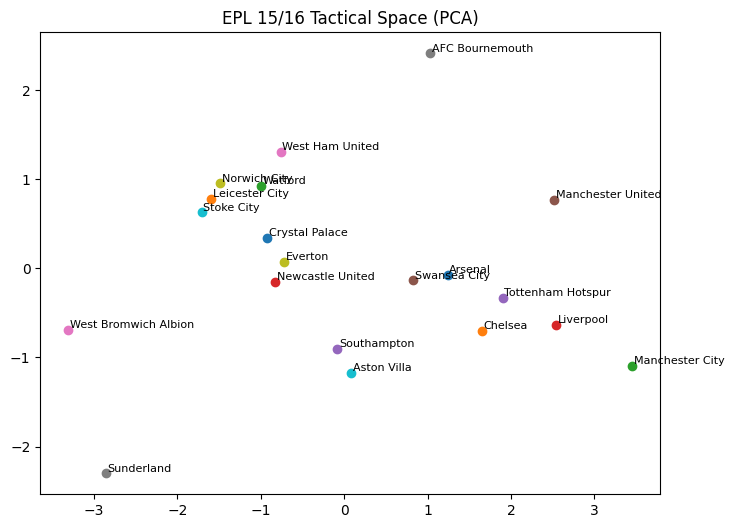

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

plt.figure(figsize=(8,6))
for i, team in enumerate(team_season_z["team_name"]):
    plt.scatter(X_2d[i,0], X_2d[i,1])
    plt.text(X_2d[i,0]+0.02, X_2d[i,1]+0.02, team, fontsize=8)

plt.title("EPL 15/16 Tactical Space (PCA)")
plt.show()
